In [1]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
from skimage import feature
from skimage import filters
from skimage import exposure
from skimage import img_as_float
from skimage import io

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Sampler

from datetime import datetime
from tqdm.notebook import tqdm as tqdm
from utils import mkdir, rmdir
from ipywidgets import Output

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 10})
plt.style.use('ggplot')

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
NUM_WORKERS = 8
CLASS_NUM = 43

IMG_SIZE = (64, 64)

MAX_ROTATION = 30

MIN_BRIGHTNESS = 0.4
MAX_BRIGHTNESS = 2.0

MIN_CONTRAST = 0.4
MAX_CONTRAST = 2.0

MIN_SATURATION = 0.4
MAX_SATURATION = 1.6

DISTORTION = 0.4
MAX_TRANSITION = 0.25

MIN_SCALE = 0.9
MAX_SCALE = 1.1

NOISE_STD = 0.02

In [4]:
def RandomNoise(tensor):
    std = np.random.uniform(0, NOISE_STD)
    return torch.clamp(tensor + torch.FloatTensor(tensor.size()).normal_(0, std), 0, 1)

In [5]:
my_transforms = {
    'default': T.Compose([
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor()
    ]),
    'train': T.Compose([
        T.RandomAffine(MAX_ROTATION, (MAX_TRANSITION, MAX_TRANSITION), (MIN_SCALE, MAX_SCALE)),
        # T.RandomPerspective(DISTORTION),
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
        T.Lambda(RandomNoise),
    ]),
    'test': T.Compose([
        T.Resize(IMG_SIZE),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
    ])
}

In [6]:
class MyTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        self.image_transform = T.Compose([
            T.ColorJitter((MIN_BRIGHTNESS, MAX_BRIGHTNESS),
            (MIN_CONTRAST, MAX_CONTRAST), (MIN_SATURATION,MAX_SATURATION)),
            T.ToTensor(),
            T.Lambda(RandomNoise),
        ])
        return
    
    def __call__(self, img, mask, is_test):
        w, h = img.size

        if not is_test:
            while True:
                crop_left, crop_right = sorted(np.random.randint(0, w, size=2))
                if crop_right - crop_left > w * 0.9:
                    break
            
            while True:
                crop_top, crop_bottom = sorted(np.random.randint(0, h, size=2))
                if crop_bottom - crop_top > h * 0.9:
                    break
                    
            angle = np.random.uniform(-180, 180)
            translate =  tuple(np.random.uniform(-16, 16, size=(2,)))
            scale = np.random.uniform(0.7, 1.1)
            shear = np.random.uniform(-0, 0)
            fillcolor = 0 # np.random.randint(0, 256)
            
            img = TF.affine(img, angle, translate, scale, shear, fillcolor=fillcolor)
            mask = TF.affine(mask, angle, translate, scale, shear)

            img = TF.crop(img, crop_top, crop_left, crop_bottom - crop_top, crop_right - crop_left)
            mask = TF.crop(mask, crop_top, crop_left, crop_bottom - crop_top, crop_right - crop_left)
        
        img = TF.resize(img, self.image_size, interpolation=2)
        mask = np.array(TF.resize(mask, self.image_size, interpolation=2))
        
        if is_test:
            img = TF.to_tensor(img)
        else:
            img = self.image_transform(img)
        mask = TF.to_tensor(mask)
        return img, mask

In [7]:
train_path = 'dataset/train.csv'
test_path = 'dataset/test.csv'

image_path = 'dataset/images/'

In [156]:
def load_image(path, as_gray=True):
    return Image.fromarray(io.imread(path, as_gray=as_gray))


tensor([[[0.9686, 0.9686, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


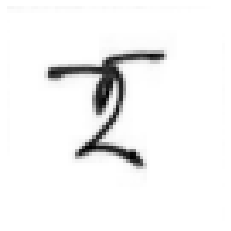

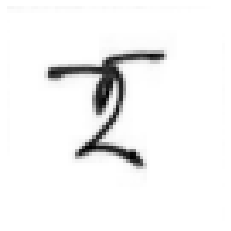

tensor([[[0.9922, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9922],
         [0.9882, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9922],
         [0.9922, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9922, 0.9922,  ..., 0.9922, 0.9882, 0.9922],
         [0.9882, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [0.9882, 0.9922, 0.9922,  ..., 0.9922, 0.9961, 0.9961]]])
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


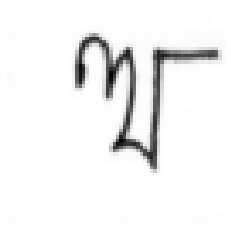

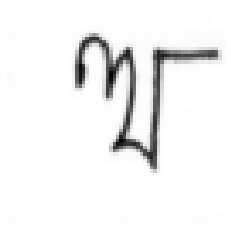

tensor([[[0.9843, 0.9843, 0.9804,  ..., 0.9843, 0.9843, 0.9882],
         [0.9882, 0.9882, 0.9922,  ..., 0.9922, 0.9922, 0.9843],
         [0.9882, 0.9882, 0.9922,  ..., 0.9882, 0.9882, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9922],
         [0.9922, 0.9882, 0.9882,  ..., 0.9922, 0.9843, 0.9843],
         [0.9843, 0.9804, 0.9882,  ..., 0.9882, 0.9882, 0.9882]]])
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


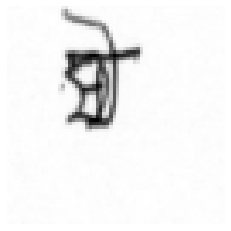

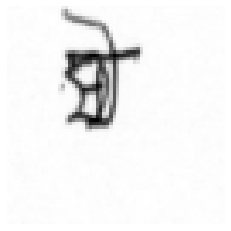

tensor([[[0.9804, 0.9882, 0.9882,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961],
         ...,
         [0.9882, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000]]])
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


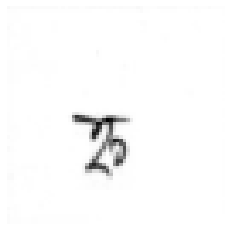

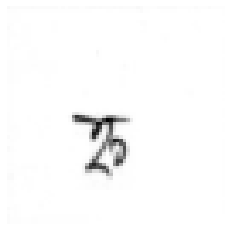

tensor([[[0.9725, 0.9843, 0.9804,  ..., 0.9882, 0.9843, 0.9804],
         [0.9765, 0.9804, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
         [0.9843, 0.9843, 0.9922,  ..., 0.9882, 0.9843, 0.9804],
         ...,
         [0.9843, 0.9843, 0.9882,  ..., 0.9804, 0.9843, 0.9765],
         [0.9804, 0.9804, 0.9843,  ..., 0.9804, 0.9882, 0.9804],
         [0.9765, 0.9765, 0.9804,  ..., 0.9882, 0.9882, 0.9804]]])
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>


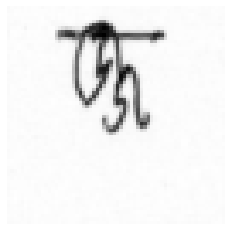

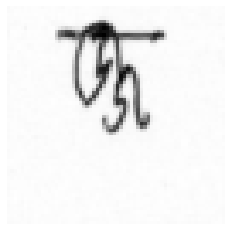

In [157]:
class BengaliDataset(Dataset):
    def __init__(self, path, image_path, 
                 target='classify',
                 transform=my_transforms['default'],
                 is_train=True, verbose=True):        
        self.is_train = is_train
        # if not isinstance(transform, tuple):
        #     self.transform = (transform, transform)
        # else:
        #     self.transform = transform    
        # self.transform = transform
        self.transform = transform
        
        assert target in {'reconstruct', 'classify'}
        self.target = target
        
        # reading labels
        df = pd.read_csv(path)
        
        df = df[(df.vowel_diacritic == 0) & (df.consonant_diacritic == 0)]
        
        self.image_ids = df.image_id.unique()
        self.length = len(self.image_ids)
        
        if self.is_train:
            self.labels = df[['grapheme_root','vowel_diacritic','consonant_diacritic']].values
        else:
            self.labels = [None] * self.length
        
        # reading images
        iterator = [os.path.join(image_path, f'{x}.png') for x in self.image_ids]
        with mp.Pool(16) as pool:
            iterator = pool.imap(load_image, iterator)
            if verbose:
                iterator = tqdm(iterator, total=len(self.image_ids))
            self.images = list(iterator)
        
    def __getitem__(self, idx):
        if self.target == 'reconstruct':            
            img = self.images[idx]
            # img1, img2 = self.transform(img, img, not self.is_train)
            # return img1, img2
            img = self.transform(img)
            return img, img
        return self.transform(self.images[idx]), self.labels[idx]
    
    def __len__(self):
        return self.length
    
Autoencoder_Train = BengaliDataset(train_path, image_path, target='reconstruct',
    #transform=MyTransform((64,64)),
    transform=my_transforms['default'],
    is_train=True, verbose=True)
# Autoencoder_Test = BengaliDataset(test_path, image_path, target='reconstruct',
#     transform=(my_transforms['test'], my_transforms['default']),
#     is_train=False, verbose=True)

for idx in range(5):
    img, target = Autoencoder_Train[idx]
    print(target)
    print(target.size(), type(target))
    print(img.size(), type(img))
    
    plt.imshow(TF.to_pil_image(img), cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(TF.to_pil_image(target), cmap='gray')
    plt.axis('off')
    plt.show()

# Variational Autoencoder

In [158]:
class EncoderLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(EncoderLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01,inplace=True),
            nn.BatchNorm2d(out_ch),
#             nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.01,inplace=True),
#             nn.BatchNorm2d(out_ch),
        )
        self.pool = nn.MaxPool2d(2)
        self.residuals = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        y = self.layers(x)
        y = self.pool(y)
        return y
#         x = self.residuals(x)
#         x = self.pool(x)
#         return x + y
        

# x = torch.FloatTensor(size=(1,1,64,64))
# test_encoder_layer = EncoderLayer(1, 16)
# test_encoder_layer(x).size()

In [159]:
class DecoderLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DecoderLayer, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layers = nn.Sequential(
            #nn.LeakyReLU(0.01,inplace=True),
            #nn.BatchNorm2d(in_ch),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01,inplace=True),
            nn.BatchNorm2d(out_ch),
        )
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.residuals = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        y = self.conv_transpose(x)
        y = self.layers(y)
        return y
#         x = self.upsample(x)
#         x = self.residuals(x)
#         return x + y
    
x = torch.FloatTensor(size=(16,128,4,4))
test_decoder_layer = DecoderLayer(128, 64)
print(test_decoder_layer)
test_decoder_layer(x).size()

DecoderLayer(
  (conv_transpose): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (layers): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (residuals): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
)


torch.Size([16, 64, 8, 8])

In [160]:
class VAE(nn.Module):
    def __init__(self, code_shape=32, filters=16, input_shape=(64,64)):
        super(VAE, self).__init__()  
        
        # params
        self.input_shape = input_shape
        self.hidden_shape = (input_shape[0] // 16, input_shape[1] // 16)
        self.code_shape = code_shape
        self.filters = filters
        
        # encoder convs
        self.input_layer = nn.BatchNorm2d(1)
        self.encoder_convs = nn.Sequential(
            EncoderLayer(1, filters), # 1x64x64 -> 16x32x32
            EncoderLayer(filters, filters * 2), # 16x32x32 -> 32x16x16
            EncoderLayer(filters * 2, filters * 4), # 32x16x16 -> 64x8x8
            EncoderLayer(filters * 4, filters * 8), # 64x8x8 -> 128x4x4
        )
        
        # encoder dense
        num_features = self.filters * 8 * np.prod(self.hidden_shape)
        self.encoder_fcn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.LeakyReLU(0.01),
#             nn.BatchNorm1d(512),
        )
        self.mean_layer = nn.Linear(512, self.code_shape)
        self.logvar_layer = nn.Linear(512, self.code_shape)
    
        # decoder convs
        self.decoder_fcn = nn.Sequential(
            nn.Linear(self.code_shape, 512),
            nn.LeakyReLU(0.01),
#             nn.BatchNorm1d(512),
            nn.Linear(512, num_features)
        )
            
        self.decoder_convs = nn.Sequential(
            DecoderLayer(filters * 8, filters * 4), # 128x4x4 -> 64x8x8
            DecoderLayer(filters * 4, filters * 2), # 64x8x8 -> 32x16x16
            DecoderLayer(filters * 2, filters), # 32x16x16 -> 16x32x32
            DecoderLayer(filters, filters), # 16x32x32 -> 16x64x64
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(filters, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.input_layer(x)
        x = self.encoder_convs(x)
        x = self.encoder_fcn(x)
        
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + std * eps
    
    def decode(self, x):
        x = self.decoder_fcn(x)
        x = x.view(-1, self.filters * 8, *self.hidden_shape)
        x = self.decoder_convs(x)
        return self.output_layer(x)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrize(mean, logvar)
        return self.decode(z), mean, logvar
    
####

vae = VAE(64, filters=16, input_shape=(64,64))
# vae test

x = torch.FloatTensor(size=(16, 1, 64, 64))
print('Input:', x.size())

mean, logvar = vae.encode(x)
print('Encoded:', mean.size(), logvar.size())

decoded = vae.decode(mean)
print('Decoded:', decoded.size())

Input: torch.Size([16, 1, 64, 64])
Encoded: torch.Size([16, 64]) torch.Size([16, 64])
Decoded: torch.Size([16, 1, 64, 64])


In [161]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.value = 0
        self.count = 0
    
    def update(self, value, count=1):
        value = float(value)
        self.value = (self.value * self.count + value * count) / (self.count + count)
        self.count += count
    
    def __repr__(self):
        return f'{self.value:.5f}'

# Train

In [187]:
num_epochs = 1024 * 6
batch_size = 32
batch_per_epoch = 512

num_test_batches = 4

lambda_kld = 1

In [181]:
num_workers = 8

train_loader = DataLoader(Autoencoder_Train, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, drop_last=True)
test_loader = DataLoader(Autoencoder_Train, batch_size=16, shuffle=False)
print('Train len:', len(train_loader))
batch_per_epoch = len(train_loader)

Train len: 748


### Initializing

In [164]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [165]:
net = VAE(4, filters=32, input_shape=(64,64))
net = net.to(device)

In [175]:
def lr_scheduler(epoch):
    if epoch < 128:
        return 1
    if epoch < 512:
        return 1e-0
    if epoch < 768:
        return 1e-0
    return 1e-0

In [188]:
optimizer = optim.Adamax(net.parameters(), lr=1e-5, betas=(0.99, 0.9995))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)

In [189]:
def loss_function(x, x_gt, mean, logvar):
    #bce = nn.BCELoss()(x.view(-1, 64*64), x_gt.view(-1, 64*64))
    bce = nn.MSELoss()(x.view(-1, 64*64), x_gt.view(-1, 64*64))
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)
    kld = kld.sum()
    if lambda_kld == 0:
        kld = torch.FloatTensor([0]).to(device)
    else:
        kld = kld * lambda_kld
    return bce, kld

In [190]:
metrics_output = Output()
plot_output = Output()

In [ ]:
pbar = tqdm(total=num_epochs * batch_per_epoch)
display(metrics_output)
display(plot_output)

for epoch in range(num_epochs):
    next_epoch = batch_per_epoch * (epoch + 1)
        
    avg_loss = AverageMeter()
    for it, (X_batch, Xgt_batch) in zip(range(batch_per_epoch), train_loader):
        net.train()
        X_batch = X_batch.to(device)
        Xgt_batch = Xgt_batch.to(device)
        
        
        optimizer.zero_grad()
        
        Xpred_batch, mean, logvar = net(X_batch)
        bce, kld = loss_function(Xpred_batch, Xgt_batch, mean, logvar)
        if lambda_kld == 0:
            loss = bce
        else:
            loss = bce + kld
        loss.backward()
        
        avg_loss.update(loss.item(), X_batch.shape[0])
        
        optimizer.step()
                
        if pbar.n % 4 == 0:
            with metrics_output:
                metrics_output.clear_output(wait=True)
                lr = optimizer.param_groups[0]['lr']
                print(f"[E{epoch:04d}, {next_epoch}, {lr}] loss: " +
                      f"{loss.item():10.5f} = {bce.item():10.5f} + {kld.item():10.5f}")
            pbar.set_description(f'loss: {avg_loss}')
        
        if pbar.n % 256 == 0:
            net.eval()
            with torch.no_grad():
                img = []
                for it, (X_batch, Xgt_batch) in zip(range(num_test_batches), test_loader):
                    X_batch = X_batch.to(device)
                    mean, logvar = net.encode(X_batch)
                    Xpred_batch = net.decode(mean).to('cpu')

                    loc = torch.cat([
                        torch.cat(list(Xpred_batch), dim=2),
                        torch.cat(list(Xgt_batch), dim=2)
                    ], dim=1)
                    img.append(loc)
                img = torch.cat(img, dim=1)
            with plot_output:
                plot_output.clear_output(wait=True)
                _, ax = plt.subplots(1, 1, figsize=(16,10))
                ax.imshow(T.ToPILImage()(img), cmap='gray')
                ax.axis('off')
                plt.show()
        pbar.update(1)
        # end of iteration
    scheduler.step(epoch)
    # end of epoch

Output()

Output()